In [58]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [40]:
df_operon = pd.read_csv("operon.txt",                 
                        delim_whitespace=True, 
                        comment="#",
                        names=["OPERON_ID",
                               "OPERON_NAME",
                               "FIRSTGENEPOSLEFT",
                               "LASTGENEPOSRIGHT",
                               "REGULATIONPOSLEFT",
                               "REGULATIONPOSRIGHT",
                               "OPERON_STRAND",
                               "OPERON_INTERNAL_COMMENT",
                               "KEY_ID_ORG"]).drop_duplicates().dropna(how="all")


df_interaction = pd.read_csv("interaction.txt",                 
                             #delim_whitespace=True,
                             sep="\t",
                             comment="#",
                             names=["INTERACTION_ID",
                                    "REGULATOR_ID",
                                    "PROMOTER_ID",
                                    "SITE_ID",
                                    "INTERACTION_FUNCTION",
                                    "CENTER_POSITION",
                                    "INTERACTION_FIRST_GENE_ID",
                                    "AFFINITY_EXP",
                                    "INTERACTION_NOTE",
                                    "INTERACTION_INTERNAL_COMMENT",
                                    "INTERACTION_SEQUENCE",
                                    "KEY_ID_ORG",
                                    "INTERACTION_NOTE_WEB"]).drop_duplicates().dropna(how="all").drop(0)

df_genetic_network = pd.read_csv("genetic_network.txt",                 
                             #delim_whitespace=True,
                             sep="\t",
                             comment="#",
                             names=["REGULATOR_ID",
                                    "REGULATOR_NAME",
                                    "REGULATED_ID",
                                    "REGULATED_NAME",
                                    "FUNCTION_INTERACTION",
                                    "EVIDENCE",
                                    "REGULATOR_TYPE",
                                    "REGULATED_TYPE"]).dropna(how="all").drop_duplicates().drop(0)


In [41]:
df_genetic_network.head()

,REGULATOR_ID,REGULATOR_NAME,REGULATED_ID,REGULATED_NAME,FUNCTION_INTERACTION,EVIDENCE,REGULATOR_TYPE,REGULATED_TYPE
1,ECK120011186,Fis,ECK120002550,tyrV,+,Gene expression analysis;Inferred from direct ...,tf,gene
2,ECK120011186,Fis,ECK120002551,valT,+,Inferred from direct assay;Inferred from expre...,tf,gene
3,ECK120011186,Fis,ECK120002552,valU,+,A person inferred or reviewed a computer infer...,tf,gene
4,ECK120011186,Fis,ECK120002555,valX,+,A person inferred or reviewed a computer infer...,tf,gene
5,ECK120011186,Fis,ECK120002556,valY,+,A person inferred or reviewed a computer infer...,tf,gene


In [43]:
df_genetic_network["REGULATOR_TYPE"].unique(), df_genetic_network["REGULATED_TYPE"].unique() 

(array(['tf', 'sigma'], dtype=object),
 array(['gene', 'operon', 'tf', 'sigma'], dtype=object))

In [290]:
# Select transcription factor regulations to transcription factor
# df_tf_tf = df_genetic_network.loc[(df_genetic_network["REGULATOR_TYPE"] == 'tf') & 
#                                   (df_genetic_network["REGULATED_TYPE"] == 'tf')]

df_tf_tf = df_genetic_network#.loc[(df_genetic_network["REGULATED_TYPE"] == 'tf')]

In [291]:
G = nx.Graph()
G.add_edges_from(df_tf_tf[["REGULATOR_ID","REGULATED_ID"]].to_numpy())

In [292]:
G.number_of_nodes(), G.number_of_edges()

(3734, 10680)

In [293]:
A = nx.adjacency_matrix(G).todense()

/tmp/ipykernel_60405/2684795532.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


In [294]:
def sample_a_subnet(m, size):
    """Sample a subnetwork from the adjecancy matrix m.
     
       The size of the subnetwork is (size, size)
    """    
    rows = np.random.choice(range(m.shape[0]), size=size, replace=False)
    columns = np.random.choice(range(m.shape[1]), size=size, replace=False)
#     return np.array([[m[i,j] for j in range(m.shape[1]) if j in columns] 
#                              for i in range(m.shape[0]) if i in rows])
    return m[np.ix_(columns, rows)]

def find_p(m, exclude_self_regulations=True):
    """Probability of having an edge betwen to randomly selected nodes
    
    """
    m2 = m - np.diag(np.diag(m))
    n = m.shape[0]
    if exclude_self_regulations:                
        compelete_edges = n*(n-1)/2
        total_edges = np.sum(m2)/2 
        return total_edges/compelete_edges
    else:
        compelete_edges = n*(n+1)/2       
        total_edges = np.sum(np.diag(m)) + np.sum(m2)/2 
        return total_edges/compelete_edges
    

In [295]:
np.array([2**i for i in range(2,int(np.log2(max_size))+1)] + [max_size])


array([  4,   8,  16,  32,  64, 128, 156])

In [319]:

max_size = G.number_of_nodes()
ns = np.array([2**i for i in range(2,int(np.log2(max_size))+1)] + [max_size])
sample_sizes = np.array([100000, 10000, 10000, 10000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])
#[i for i in range(4, max_size+1, step)])
#repeats = 1000
#samples_large = np.zeros((ns.shape[0], repeats))
samples_large = []
for i, (n, repeats) in enumerate(zip(ns, sample_sizes)):
    samples_large.append([])
    for r in range(repeats):
        s = sample_a_subnet(A, n)
        p = find_p(s)
        samples_large[-1].append(p)

In [320]:
ns

array([   4,    8,   16,   32,   64,  128,  256,  512, 1024, 2048, 3734])

In [321]:
for n, sample in zip(ns, samples_large):
    print(n, np.mean(sample), np.std(sample))

4 0.0015075 0.01336006484411243
8 0.0015892857142857143 0.007862802344856808
16 0.00151 0.004974703787943336
32 0.001541532258064516 0.00343327703900907
64 0.0015820932539682539 0.002413174804464199
128 0.00150412155511811 0.0015480173666490243
256 0.0015286764705882353 0.0010699892665204872
512 0.0015351333170254401 0.0007131867948987279
1024 0.0015218499893084067 0.00047419105008193486
2048 0.0015062763342696627 0.0002677685674139507
3734 0.0015222920948112426 1.5389801885388267e-07


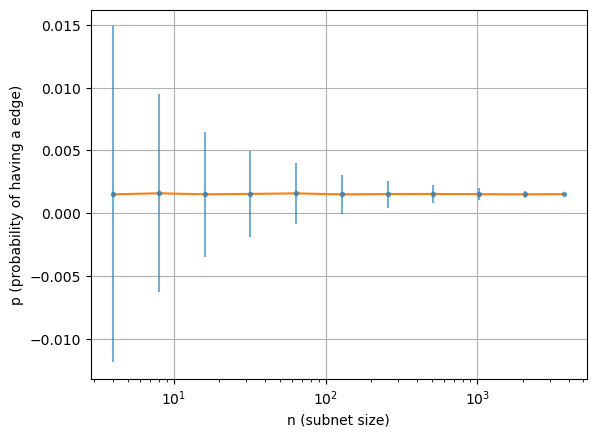

In [325]:
plt.errorbar(ns, [np.mean(sample) for sample in samples_large],
                 [np.std(sample) for sample in samples_large],
                 linestyle='None', marker='.', alpha=.6)
plt.plot(ns, [np.mean(sample) for sample in samples_large], alpha=1)
plt.xlabel("n (subnet size)")
plt.ylabel("p (probability of having a edge)")
plt.grid();plt.xscale('log')

In [327]:
# Select transcription factor regulations to transcription factor
df_tf_tf = df_genetic_network.loc[(df_genetic_network["REGULATOR_TYPE"] == 'tf') & 
                                  (df_genetic_network["REGULATED_TYPE"] == 'tf')]

G = nx.Graph()
G.add_edges_from(df_tf_tf[["REGULATOR_ID","REGULATED_ID"]].to_numpy())
print(G.number_of_nodes(), G.number_of_edges())
A = nx.adjacency_matrix(G).todense()
max_size = G.number_of_nodes()

184 438


/tmp/ipykernel_60405/3520698685.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


In [329]:
step = 4
ns = np.array([i for i in range(step, max_size+step, step)])
sample_sizes = np.array([100000] * 4 + [10000] * 4 + [1000] * (ns.shape[0] - 8))
samples = []
for i, (n, repeats) in enumerate(zip(ns, sample_sizes)):
    samples.append([])
    for r in range(repeats):
        s = sample_a_subnet(A, n)
        p = find_p(s)
        samples[-1].append(p)        

0.02189112615823236


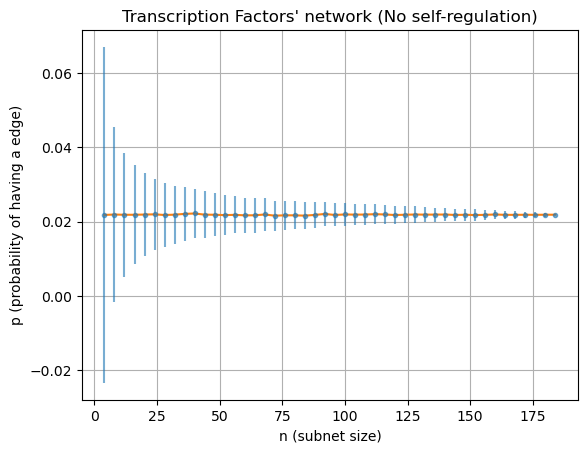

In [331]:
print(np.mean(samples[-1]))
plt.errorbar(ns, [np.mean(sample) for sample in samples],
                 [np.std(sample) for sample in samples],
                 linestyle='None', marker='.', alpha=.6)
plt.plot(ns, [np.mean(sample) for sample in samples], alpha=1)
plt.xlabel("n (subnet size)")
plt.ylabel("p (probability of having a edge)")
plt.title("Transcription Factors' network (No self-regulation)")
plt.grid()

In [332]:
step = 4
ns = np.array([i for i in range(step, max_size+step, step)])
sample_sizes = np.array([100000] * 4 + [10000] * 4 + [1000] * (ns.shape[0] - 8))
samples2 = []
for i, (n, repeats) in enumerate(zip(ns, sample_sizes)):
    samples2.append([])
    for r in range(repeats):
        s = sample_a_subnet(A, n)
        p = find_p(s, exclude_self_regulations=False)
        samples2[-1].append(p)         

0.021890452408930672


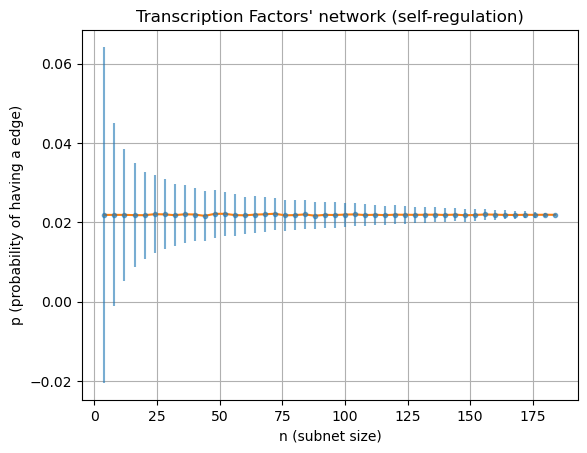

In [333]:
print(np.mean(samples2[-1]))
plt.errorbar(ns, [np.mean(sample) for sample in samples2],
                 [np.std(sample) for sample in samples2],
                 linestyle='None', marker='.', alpha=.6)
plt.plot(ns, [np.mean(sample) for sample in samples2], alpha=1)
plt.xlabel("n (subnet size)")
plt.ylabel("p (probability of having a edge)")
plt.title("Transcription Factors' network (self-regulation)")
plt.grid()

# Activation only

In [336]:
df_tf_tf = df_genetic_network.loc[(df_genetic_network["REGULATOR_TYPE"] == 'tf') & 
                                  (df_genetic_network["REGULATED_TYPE"] == 'tf') &
                                  (df_genetic_network["FUNCTION_INTERACTION"] == '+')]

G = nx.Graph()
G.add_edges_from(df_tf_tf[["REGULATOR_ID","REGULATED_ID"]].to_numpy())
print(G.number_of_nodes(), G.number_of_edges())
A = nx.adjacency_matrix(G).todense()
max_size = G.number_of_nodes()


115 182


/tmp/ipykernel_60405/3544779679.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


In [337]:
step = 4
ns = np.array([i for i in range(step, max_size, step)] + [max_size])
sample_sizes = np.array([100000] * 4 + [10000] * 4 + [1000] * (ns.shape[0] - 8))
samples_act = []
for i, (n, repeats) in enumerate(zip(ns, sample_sizes)):
    samples_act.append([])
    for r in range(repeats):
        s = sample_a_subnet(A, n)
        p = find_p(s, exclude_self_regulations=True)
        samples_act[-1].append(p)         

0.025173989321128905


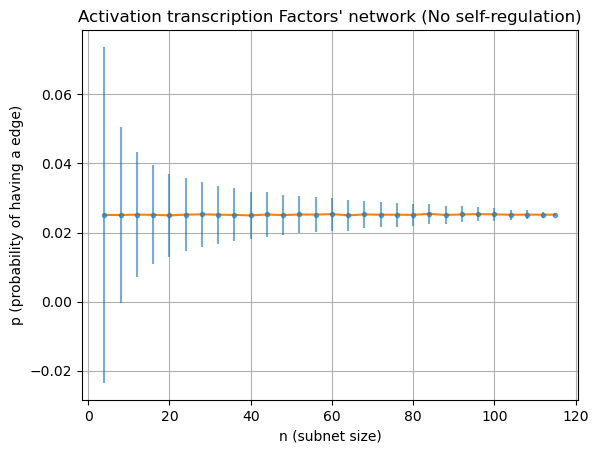

In [338]:
print(np.mean(samples_act[-1]))
plt.errorbar(ns, [np.mean(sample) for sample in samples_act],
                 [np.std(sample) for sample in samples_act],
                 linestyle='None', marker='.', alpha=.6)
plt.plot(ns, [np.mean(sample) for sample in samples_act], alpha=1)
plt.xlabel("n (subnet size)")
plt.ylabel("p (probability of having a edge)")
plt.title("Activation transcription Factors' network (No self-regulation)")
plt.grid()

# Inhibition Only

In [339]:

df_tf_tf = df_genetic_network.loc[(df_genetic_network["REGULATOR_TYPE"] == 'tf') & 
                                  (df_genetic_network["REGULATED_TYPE"] == 'tf') &
                                  (df_genetic_network["FUNCTION_INTERACTION"] == '-')]

G = nx.Graph()
G.add_edges_from(df_tf_tf[["REGULATOR_ID","REGULATED_ID"]].to_numpy())
print(G.number_of_nodes(), G.number_of_edges())
A = nx.adjacency_matrix(G).todense()
max_size = G.number_of_nodes()


156 238


/tmp/ipykernel_60405/1208616308.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


In [340]:
step = 4
ns = np.array([i for i in range(step, max_size, step)] + [max_size])
sample_sizes = np.array([100000] * 4 + [10000] * 4 + [1000] * (ns.shape[0] - 8))
samples_inh = []
for i, (n, repeats) in enumerate(zip(ns, sample_sizes)):
    samples_inh.append([])
    for r in range(repeats):
        s = sample_a_subnet(A, n)
        p = find_p(s, exclude_self_regulations=True)
        samples_inh[-1].append(p)    

0.015820388751033913


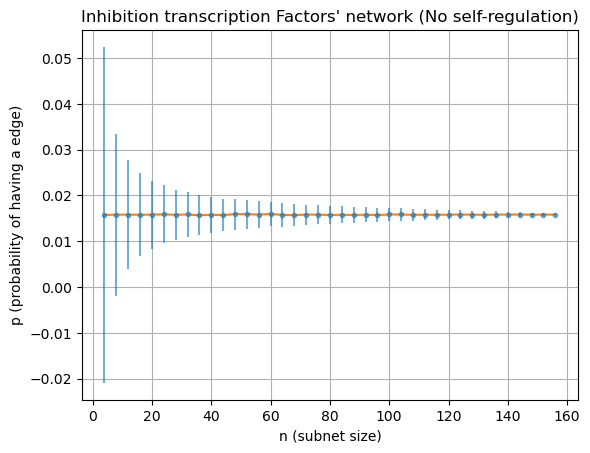

In [341]:
print(np.mean(samples_inh[-1]))
plt.errorbar(ns, [np.mean(sample) for sample in samples_inh],
                 [np.std(sample) for sample in samples_inh],
                 linestyle='None', marker='.', alpha=.6)
plt.plot(ns, [np.mean(sample) for sample in samples_inh], alpha=1)
plt.xlabel("n (subnet size)")
plt.ylabel("p (probability of having a edge)")
plt.title("Inhibition transcription Factors' network (No self-regulation)")
plt.grid()

In [355]:
max_size = 100
m_test = np.random.binomial(2, p = .1,size = (max_size,max_size) )#np.random.randint(0,2, (max_size,max_size))
m_test = (m_test + m_test.T)//2

step = 4
ns = np.array([i for i in range(step, max_size, step)] + [max_size])
sample_sizes = np.array([100000] * 10 + [10000] * 10 + [1000] * (ns.shape[0] - 20))
samples_test = []
for i, (n, repeats) in enumerate(zip(ns, sample_sizes)):
    samples_test.append([])
    for r in range(repeats):
        s = sample_a_subnet(m_test, n)
        p = find_p(s, exclude_self_regulations=True)
        samples_test[-1].append(p)    

0.05059444444444445


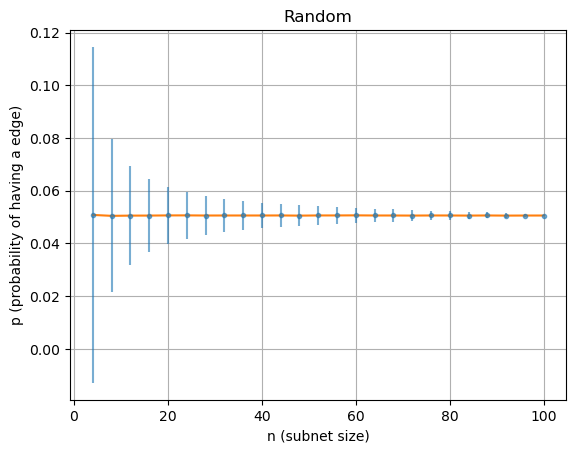

In [357]:
print(np.mean(samples_test[-1]))
plt.errorbar(ns, [np.mean(sample) for sample in samples_test],
                 [np.std(sample) for sample in samples_test],
                 linestyle='None', marker='.', alpha=.6)
plt.plot(ns, [np.mean(sample) for sample in samples_test], alpha=1)
plt.xlabel("n (subnet size)")
plt.ylabel("p (probability of having a edge)")
plt.title("Random")
plt.grid()